In [144]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../data"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    if "dont-pause" in directory:
        print(f"Skipping {directory}")
        continue

    # if "fallingDrop" not in directory:
    #     print(f"Skipping {directory}")
    #     continue

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # remove check if tuning and liveInfo files are present
    # for time, pair in data_pairs.items():
    #     if pair[0] is None or pair[1] is None:
    #         del data_pairs[time]

    data_pairs = {time: pair for time, pair in data_pairs.items(
    ) if pair[0] is not None and pair[1] is not None}

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        # assert len(corresponding_liveInfo) == len(
        #     tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        # tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

        # describe data
        # print(f"Time: {time}")
        # print(corresponding_liveInfo["avgParticlesPerCell"].describe())
        # print("")

Processing ../../data/benchmark-cluster
Processing ../../data/data-cluster-examples-pause
Processing ../../data/data-wsl2-examples-pause
Processing ../../data/benchmark-wsl2
Processing ../../data/data-wsl2-uniform-cubes
Processing ../../data/data-cluster-examples-dont-pause
Skipping ../../data/data-cluster-examples-dont-pause
Processing ../../data/benchmark-cluster/suitability-tuning-exploding
Processing ../../data/benchmark-cluster/explodingLiquid
Processing ../../data/benchmark-cluster/suitability-tuning-spinodal
Processing ../../data/benchmark-cluster/SpinodalDecompositionMPI
Processing ../../data/benchmark-cluster/explodingLiquidPause
Processing ../../data/benchmark-cluster/explodingLiquidBiggerSpacing
Processing ../../data/benchmark-cluster/SpinodalDecomposition_equilibration
Processing ../../data/benchmark-cluster/explodingLiquid-without-exploding-liquid-in-dataset
Processing ../../data/benchmark-cluster/suitability-tuning-exploding/1
Processing ../../data/benchmark-cluster/suita

# Load Data from Folders


In [146]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(214139, 30)

In [147]:
df.describe()

df.head(10)

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0             0.905797     3.0        93.75        78.75        68.75   
1             0.905797     3.0        93.75        78.75        68.75   
2             0.905797     3.0        93.75        78.75        68.75   
3             0.905797     3.0        93.75        78.75        68.75   
4             0.905797     3.0        93.75        78.75        68.75   
5             0.905797     3.0        93.75        78.75        68.75   
6             0.905797     3.0        93.75        78.75        68.75   
7             0.905797     3.0        93.75        78.75        68.75   
8             0.905797     3.0        93.75        78.75        68.75   
9             0.905797     3.0        93.75        78.75        68.75   

   estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                           85652.0     0.035863    0.107635   
1                           85652.0     0.035863    0.107635   
2                           85652.0     0.035863    0.107635   
3                           85652.0     0.035863    0.107635   
4                           85652.0     0.035863    0.107635   
5                           85652.0     0.035863    0.107635   
6                           85652.0     0.035863    0.107635   
7                           85652.0     0.035863    0.107635   
8                           85652.0     0.035863    0.107635   
9                           85652.0     0.035863    0.107635   

   maxParticlesPerCell  minParticlesPerCell  ...  threadCount    Container  \
0                  8.0                  0.0  ...         12.0  LinkedCells   
1                  8.0                  0.0  ...         12.0  LinkedCells   
2                  8.0                  0.0  ...         12.0  LinkedCells   
3                  8.0                  0.0  ...         12.0  LinkedCells   
4                  8.0                  0.0  ...         12.0  LinkedCells   
5                  8.0                  0.0  ...         12.0  LinkedCells   
6                  8.0                  0.0  ...         12.0  LinkedCells   
7                  8.0                  0.0  ...         12.0  LinkedCells   
8                  8.0                  0.0  ...         12.0  LinkedCells   
9                  8.0                  0.0  ...         12.0  LinkedCells   

   CellSizeFactor  Traversal  Load Estimator  Data Layout  Newton 3  \
0             1.0     lc_c01            none          AoS  disabled   
1             1.0     lc_c01            none          SoA  disabled   
2             1.0     lc_c04            none          AoS  disabled   
3             1.0     lc_c04            none          AoS   enabled   
4             1.0     lc_c04            none          SoA  disabled   
5             1.0     lc_c04            none          SoA   enabled   
6             1.0     lc_c08            none          AoS  disabled   
7             1.0     lc_c08            none          AoS   enabled   
8             1.0     lc_c08            none          SoA  disabled   
9             1.0     lc_c08            none          SoA   enabled   

      Reduced    Smoothed  Container_DataLayout  
0  22964350.0  22964350.0       LinkedCells_AoS  
1  21511665.0  21511665.0       LinkedCells_SoA  
2  19633948.0  19633948.0       LinkedCells_AoS  
3  13421045.0  13421045.0       LinkedCells_AoS  
4  20298967.0  20298967.0       LinkedCells_SoA  
5  14474746.0  14474746.0       LinkedCells_SoA  
6  19792369.0  19792369.0       LinkedCells_AoS  
7  13082756.0  13082756.0       LinkedCells_AoS  
8  19870901.0  19870901.0       LinkedCells_SoA  
9  13517639.0  13517639.0       LinkedCells_SoA  

[10 rows x 30 columns]

In [148]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

In [149]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    # "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    "Container",
    "Data Layout",
    "Data Layout",
    "CellSizeFactor",
    "Traversal",
    "Load Estimator",
    "Newton 3",
]

# Define Interesting Data to observe


In [150]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

In [151]:
df

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0               0.905797     3.0    93.750000    78.750000    68.750000   
1               0.905797     3.0    93.750000    78.750000    68.750000   
2               0.905797     3.0    93.750000    78.750000    68.750000   
3               0.905797     3.0    93.750000    78.750000    68.750000   
4               0.905797     3.0    93.750000    78.750000    68.750000   
..                   ...     ...          ...          ...          ...   
199             6.826244     3.0    49.561231    29.561231    37.296003   
200             6.826244     3.0    49.561231    29.561231    37.296003   
201             6.826244     3.0    49.561231    29.561231    37.296003   
202             6.826244     3.0    49.561231    29.561231    37.296003   
203             6.826244     3.0    49.561231    29.561231    37.296003   

     estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                             85652.0     0.035863    0.107635   
1                             85652.0     0.035863    0.107635   
2                             85652.0     0.035863    0.107635   
3                             85652.0     0.035863    0.107635   
4                             85652.0     0.035863    0.107635   
..                                ...          ...         ...   
199                          765275.0     0.413115    1.436037   
200                          765171.0     0.413059    1.436037   
201                          764673.0     0.413042    1.463653   
202                          764698.0     0.413114    1.436037   
203                          764413.0     0.413148    1.436037   

     maxParticlesPerCell  minParticlesPerCell  ...  threadCount  \
0                    8.0                  0.0  ...         12.0   
1                    8.0                  0.0  ...         12.0   
2                    8.0                  0.0  ...         12.0   
3                    8.0                  0.0  ...         12.0   
4                    8.0                  0.0  ...         12.0   
..                   ...                  ...  ...          ...   
199                 39.0                  0.0  ...         12.0   
200                 39.0                  0.0  ...         12.0   
201                 39.0                  0.0  ...         12.0   
202                 39.0                  0.0  ...         12.0   
203                 38.0                  0.0  ...         12.0   

            Container  CellSizeFactor       Traversal  Load Estimator  \
0         LinkedCells             1.0          lc_c01            none   
1         LinkedCells             1.0          lc_c01            none   
2         LinkedCells             1.0          lc_c04            none   
3         LinkedCells             1.0          lc_c04            none   
4         LinkedCells             1.0          lc_c04            none   
..                ...             ...             ...             ...   
199  VerletListsCells             1.0         vlc_c18            none   
200  VerletListsCells             1.0  vlc_sliced_c02            none   
201  VerletListsCells             1.0  vlc_sliced_c02            none   
202  VerletListsCells             1.0  vlc_sliced_c02            none   
203  VerletListsCells             1.0  vlc_sliced_c02            none   

     Data Layout  Newton 3      Reduced     Smoothed  Container_DataLayout  
0            AoS  disabled   22964350.0   22964350.0       LinkedCells_AoS  
1            SoA  disabled   21511665.0   21511665.0       LinkedCells_SoA  
2            AoS  disabled   19633948.0   19633948.0       LinkedCells_AoS  
3            AoS   enabled   13421045.0   13421045.0       LinkedCells_AoS  
4            SoA  disabled   20298967.0   20298967.0       LinkedCells_SoA  
..           ...       ...          ...          ...                   ...  
199          SoA   enabled   84028920.0   84028920.0  VerletListsCells_SoA  
200          

In [152]:
group_by = [
    "avgParticlesPerCell",
    "cutoff",
    "domainSizeX",
    "domainSizeY",
    "domainSizeZ",
    "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    "numCells",
    "numEmptyCells",
    "numHaloParticles",
    "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]

NLARGE = 3

# only keep rows where performance percentage is above x
print("Orignal length", len(df))

# group data on input columns
grouped = df.groupby(group_by)


def add_Speedup_column(group):
    min_smoothed = group['Smoothed'].min()
    result = group.copy()
    result['speedup'] = min_smoothed / result['Smoothed']
    return result


grouped_speedup = grouped.apply(
    add_Speedup_column).reset_index(drop=True)

grouped_speedup.drop(columns=["Smoothed", "Reduced"], inplace=True)


# only keep best 10 configurations for each group
best = grouped_speedup.groupby(group_by).apply(
    lambda x: x.nlargest(NLARGE, 'speedup')).reset_index(drop=True)

# only keep if speedup is above 0.7

# best = best[best["speedup"] > 0.5]


print("Combined length", len(best))

# only look at interesting columns
# best = best[inputs + outputs + ["speedup"]]

Orignal length 214139


/tmp/ipykernel_34137/2564448610.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speedup = grouped.apply(


Combined length 15682


/tmp/ipykernel_34137/2564448610.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best = grouped_speedup.groupby(group_by).apply(


In [153]:
best

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0                 0.019622     2.5        240.0        240.0        240.0   
1                 0.019622     2.5        240.0        240.0        240.0   
2                 0.019622     2.5        240.0        240.0        240.0   
3                 0.019622     2.5        240.0        240.0        240.0   
4                 0.019622     2.5        240.0        240.0        240.0   
...                    ...     ...          ...          ...          ...   
15677             7.061688     3.0         40.6         40.6         30.6   
15678             7.061688     3.0         40.6         40.6         30.6   
15679             7.061688     3.0         40.6         40.6         30.6   
15680             7.061688     3.0         40.6         40.6         30.6   
15681             7.061688     3.0         40.6         40.6         30.6   

       estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                              273862.0     0.020279    0.302148   
1                              273862.0     0.020279    0.302148   
2                              273862.0     0.020279    0.302148   
3                              273862.0     0.020279    0.302148   
4                              273862.0     0.020279    0.302148   
...                                 ...          ...         ...   
15677                          642370.0     0.381460    1.268165   
15678                          642370.0     0.381460    1.268165   
15679                          977718.0     0.547827    1.879647   
15680                          977718.0     0.547827    1.879647   
15681                          977718.0     0.547827    1.879647   

       maxParticlesPerCell  minParticlesPerCell  ...  skin  threadCount  \
0                     12.0                  0.0  ...   3.0          1.0   
1                     12.0                  0.0  ...   3.0          1.0   
2                     12.0                  0.0  ...   3.0          1.0   
3                     12.0                  0.0  ...   3.0          4.0   
4                     12.0                  0.0  ...   3.0          4.0   
...                    ...                  ...  ...   ...          ...   
15677                 24.0                  0.0  ...   1.0         12.0   
15678                 24.0                  0.0  ...   1.0         12.0   
15679                 49.0                  0.0  ...   1.0         12.0   
15680                 49.0                  0.0  ...   1.0         12.0   
15681                 49.0                  0.0  ...   1.0         12.0   

              Container  CellSizeFactor            Traversal  \
0      VerletListsCells             1.0       vlc_sliced_c02   
1      VerletListsCells             1.0           vlc_sliced   
2      VerletListsCells             1.0  vlc_sliced_balanced   
3      VerletListsCells             1.0       vlc_sliced_c02   
4      VerletListsCells             1.0  vlc_sliced_balanced   
...                 ...             ...                  ...   
15677  VerletListsCells             1.0              vlc_c18   
15678       LinkedCells             1.0               lc_c08   
15679       LinkedCells             1.0               lc_c08   
15680       LinkedCells             1.0               lc_c01   
15681  VerletListsCells             1.0              vlc_c01   

             Load Estimator  Data Layout  Newton 3  Container_DataLayout  \
0                      none          AoS   enabled  VerletListsCells_AoS   
1                      none          AoS   enabled  VerletListsCells_AoS   
2                      none          AoS   enabled  VerletListsCells_AoS   
3                      none          AoS   enabled  VerletListsCells_AoS   
4      neighbor-list-length          AoS   enabled  VerletListsCells_AoS   
...                     ...          ...       ...                   ...   
15677                  none          AoS   enabled  VerletLists

In [154]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


# Extract the features and the target (speedup)
features = best[inputs]


# Step 2: Standardize the features

# Step 3: Apply PCA or TSNE
# PCA example
perplexity = 50
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_iter=4000,verbose=1)
components = tsne.fit_transform(features)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 15682 samples in 0.010s...
[t-SNE] Computed neighbors for 15682 samples in 0.696s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15682
[t-SNE] Computed conditional probabilities for sample 2000 / 15682
[t-SNE] Computed conditional probabilities for sample 3000 / 15682
[t-SNE] Computed conditional probabilities for sample 4000 / 15682
[t-SNE] Computed conditional probabilities for sample 5000 / 15682
[t-SNE] Computed conditional probabilities for sample 6000 / 15682
[t-SNE] Computed conditional probabilities for sample 7000 / 15682
[t-SNE] Computed conditional probabilities for sample 8000 / 15682
[t-SNE] Computed conditional probabilities for sample 9000 / 15682
[t-SNE] Computed conditional probabilities for sample 10000 / 15682
[t-SNE] Computed conditional probabilities for sample 11000 / 15682
[t-SNE] Computed conditional probabilities for sample 12000 / 15682
[t-SNE] Computed conditional probabilities for sa

([<matplotlib.lines.Line2D object at 0x7f27b500d220>, <matplotlib.lines.Line2D object at 0x7f27777065a0>, <matplotlib.lines.Line2D object at 0x7f27b35d99d0>, <matplotlib.lines.Line2D object at 0x7f27b35dab40>], ['VerletListsCells_AoS', 'LinkedCells_SoA', 'LinkedCells_AoS', 'VerletClusterLists_SoA'])


/tmp/ipykernel_34137/1950091924.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


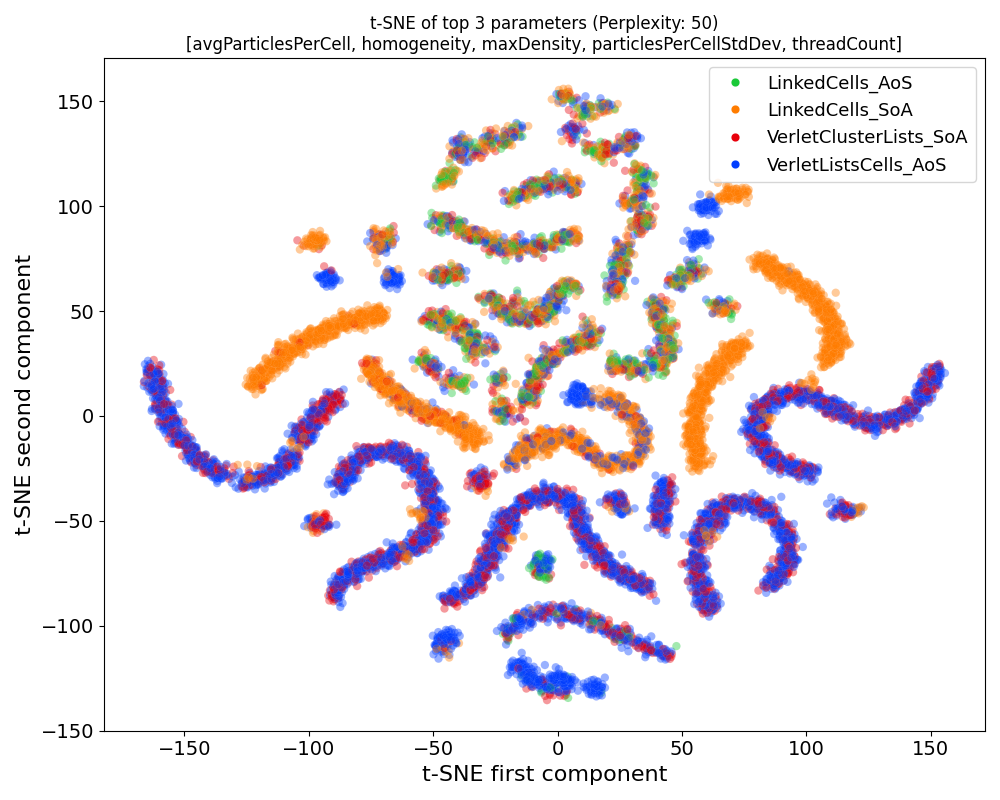

([<matplotlib.lines.Line2D object at 0x7f277dbd1850>, <matplotlib.lines.Line2D object at 0x7f277dbd0f50>, <matplotlib.lines.Line2D object at 0x7f277dbd2780>], ['VerletListsCells', 'LinkedCells', 'VerletClusterLists'])


/tmp/ipykernel_34137/1950091924.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


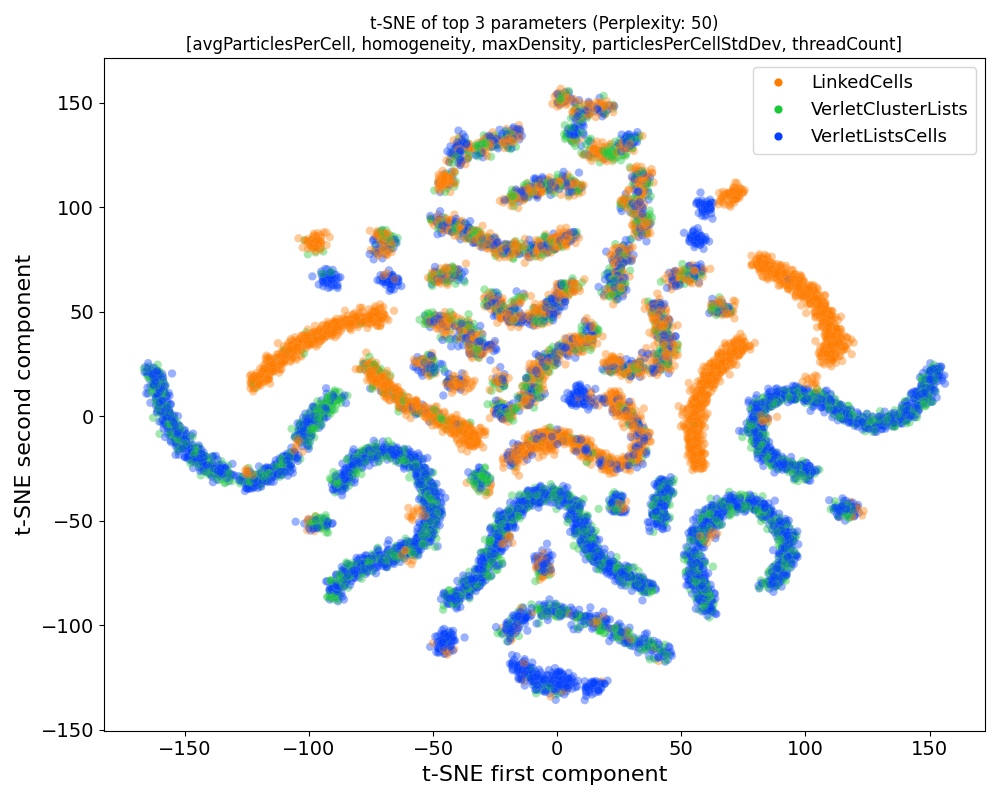

([<matplotlib.lines.Line2D object at 0x7f276ffa08f0>, <matplotlib.lines.Line2D object at 0x7f276ffa15b0>], ['AoS', 'SoA'])


/tmp/ipykernel_34137/1950091924.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


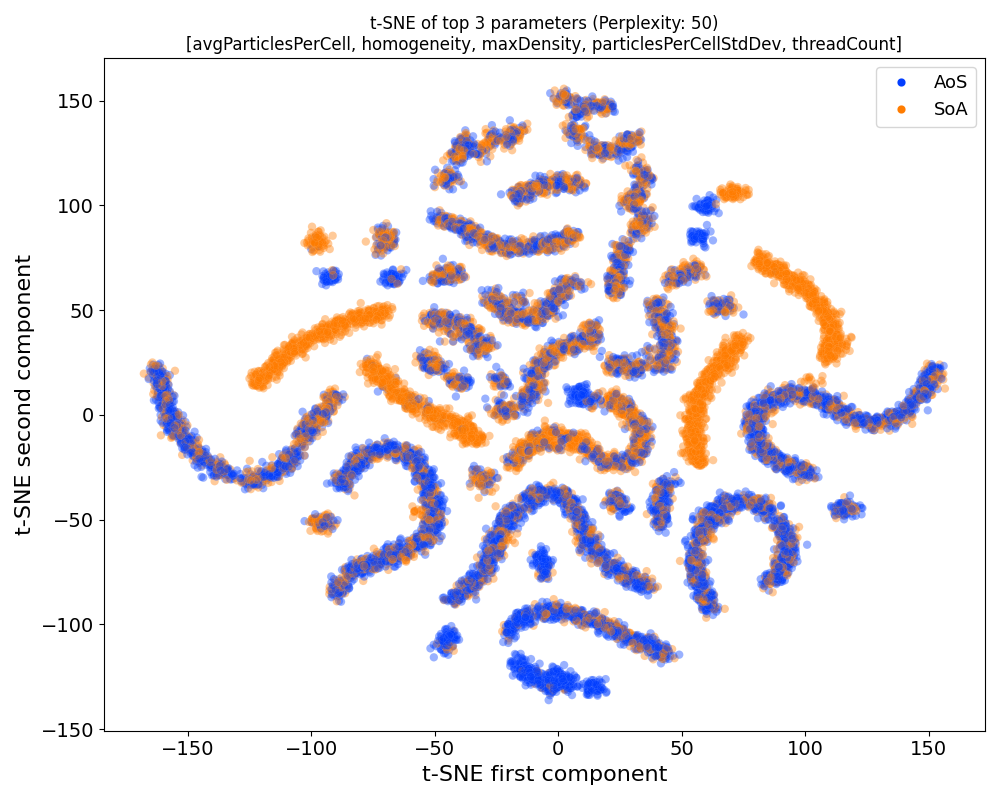

([<matplotlib.lines.Line2D object at 0x7f276b328dd0>, <matplotlib.lines.Line2D object at 0x7f276b328fe0>], ['AoS', 'SoA'])


/tmp/ipykernel_34137/1950091924.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


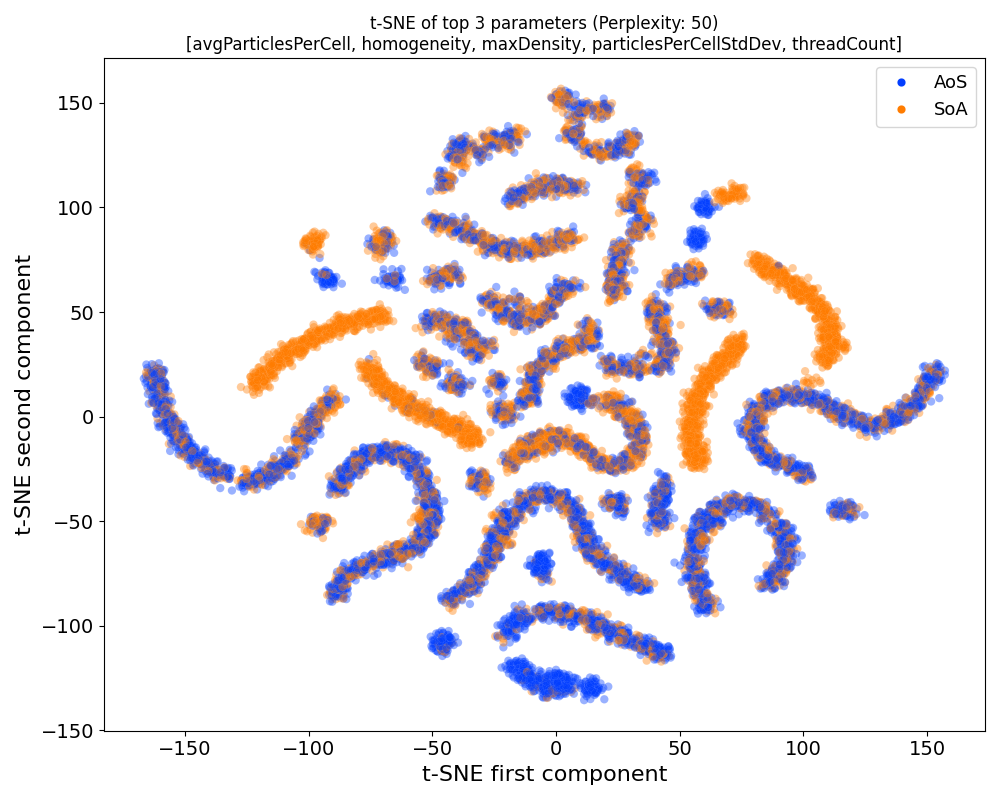

([<matplotlib.lines.Line2D object at 0x7f27709f1760>], ['1.0'])


/tmp/ipykernel_34137/1950091924.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


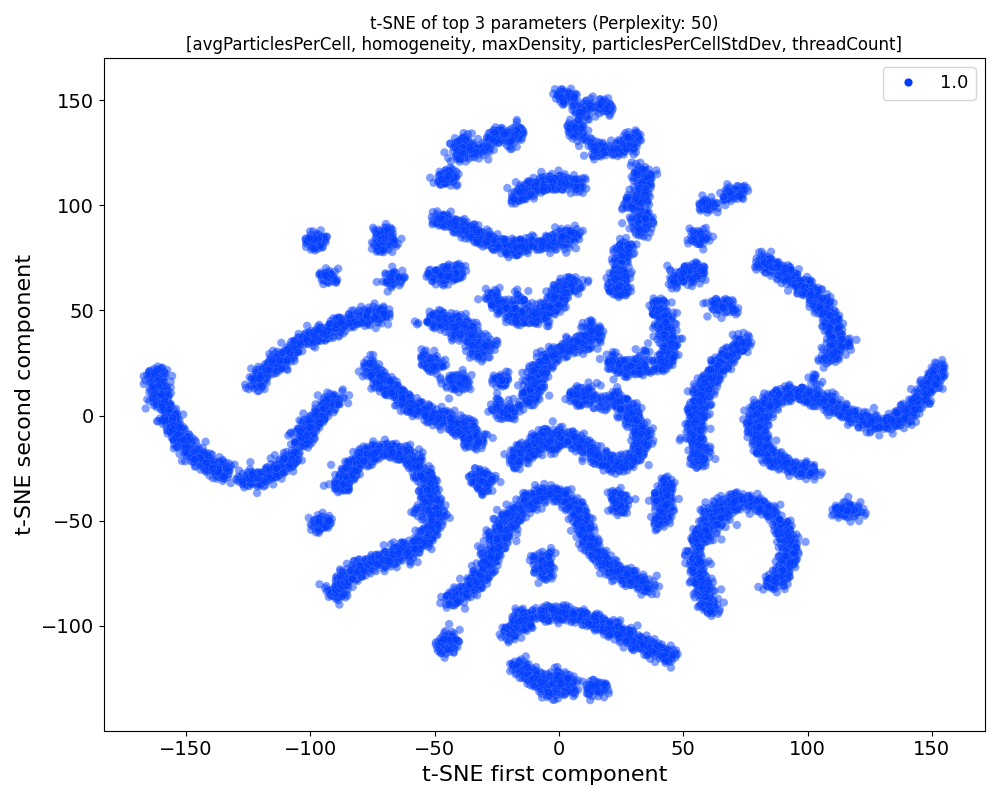

([<matplotlib.lines.Line2D object at 0x7f277745e090>, <matplotlib.lines.Line2D object at 0x7f27709f1af0>, <matplotlib.lines.Line2D object at 0x7f2777420560>, <matplotlib.lines.Line2D object at 0x7f27774235f0>, <matplotlib.lines.Line2D object at 0x7f277745da60>, <matplotlib.lines.Line2D object at 0x7f277745d760>], ['vlc_sliced_c02', 'vlc_c18', 'lc_sliced_balanced', 'lc_sliced', 'lc_sliced_c02', 'vcl_c06'])


/tmp/ipykernel_34137/1950091924.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


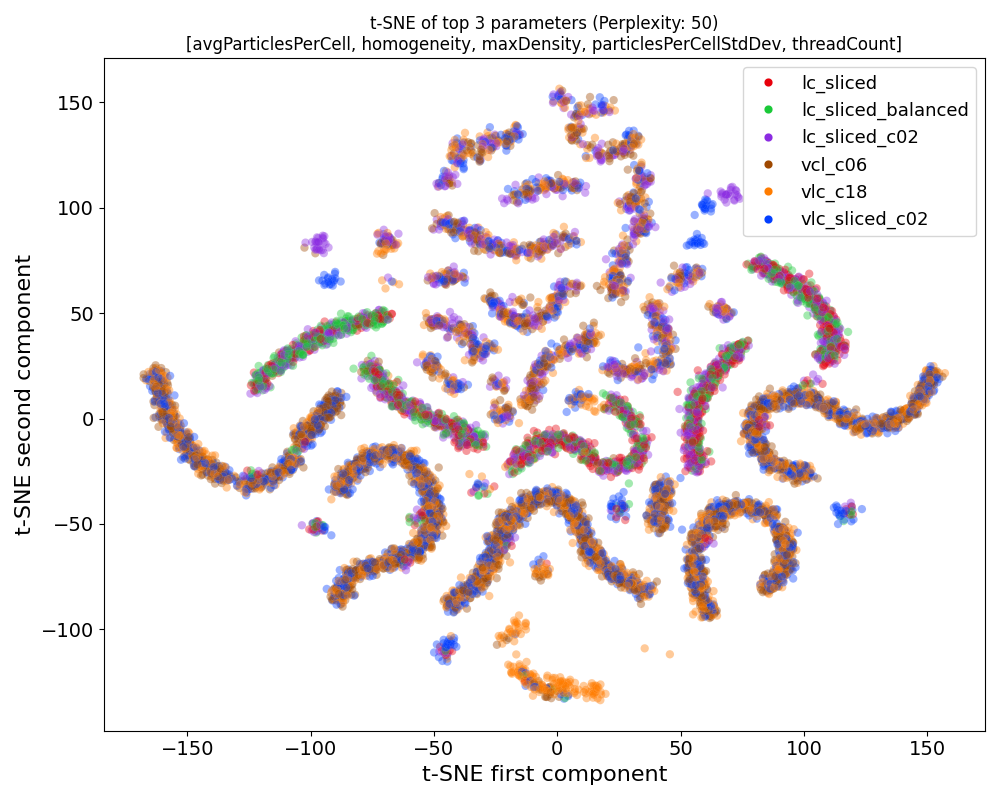

([<matplotlib.lines.Line2D object at 0x7f27b778e000>], ['none'])


/tmp/ipykernel_34137/1950091924.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


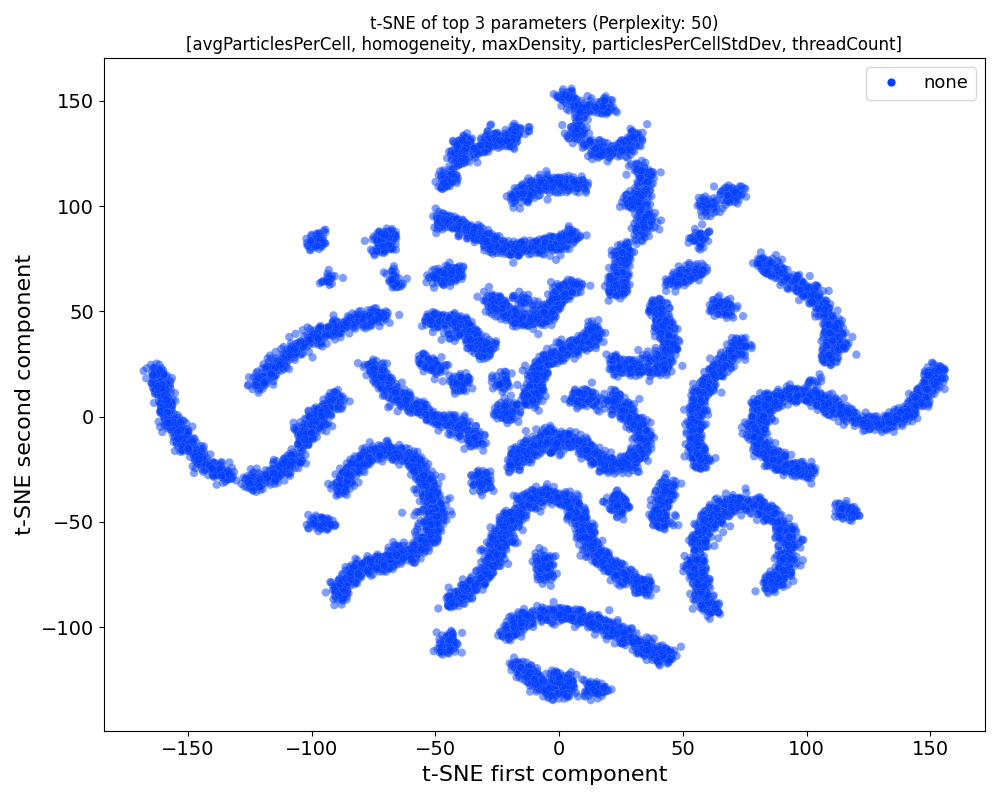

([<matplotlib.lines.Line2D object at 0x7f27bb12e3c0>, <matplotlib.lines.Line2D object at 0x7f27b7833620>], ['enabled', 'disabled'])


/tmp/ipykernel_34137/1950091924.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in scatter.legend_.legendHandles:


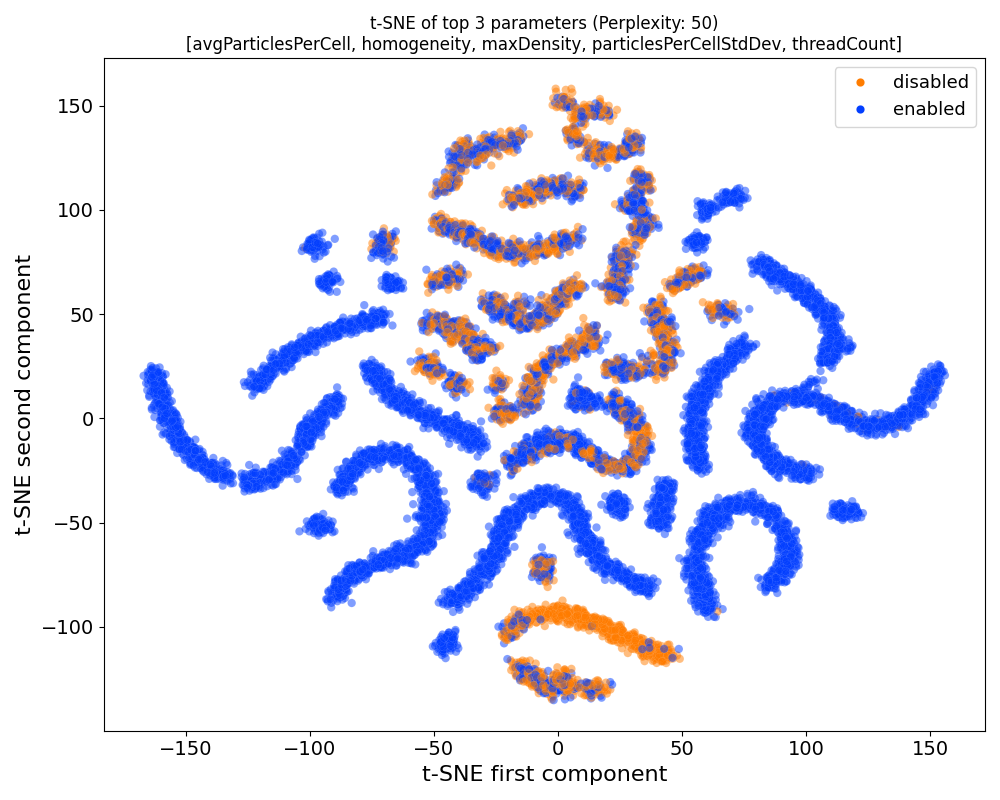

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

alpha = {
    "Container_DataLayout": 0.4,
    "Container": 0.4,
    "Data Layout": 0.4,
    "Traversal": 0.4,
    "Newton 3": 0.5,
    "CellSizeFactor": 0.5,
    "Load Estimator": 0.5,
}

CUTOFF = 0.05

for output in outputs:
    # Step 4: Visualize the data
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot()

    # Filter out rare values
    value_counts = best[output].value_counts(normalize=True)
    common_values = value_counts[value_counts >= CUTOFF].index
    mask = best[output].isin(common_values)

    # Filter the data
    filtered_data = best[mask]
    filtered_components = components[mask]

    # Get unique values and colors for common groups
    unique_values = filtered_data[output].unique()
    colors = sns.color_palette("bright", len(unique_values))

    # # add small 2d-noise to scatter plot
    filtered_components += np.random.normal(0, 2, filtered_components.shape)

    # Create a scatter plot
    # dont show speedup in legend

    scatter = sns.scatterplot(x=filtered_components[:, 0], y=filtered_components[:, 1],
                              hue=filtered_data[output], ax=ax, palette=colors,
                              linewidth=0.1, alpha=alpha[output])

    # Set labels and title
    ax.set_xlabel('t-SNE first component')
    ax.set_ylabel('t-SNE second component')
    ax.set_title(
        f't-SNE of top {NLARGE} parameters (Perplexity: {perplexity})\n[{', '.join(inputs)}]')

    # label sizes
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    # Adjust layout and display the plot
    plt.tight_layout()

    # Legend: make font size bigger. Don't use opacity in legend
    # sort legend alphabetically

    # print legend categories
    print(ax.get_legend_handles_labels())

    handles, labels = ax.get_legend_handles_labels()

    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

    ax.legend(handles=handles, labels=labels, fontsize=13)

    for lh in scatter.legend_.legendHandles:
        lh._sizes = [120]
        lh.set_alpha(1)

    plt.savefig(f"t-SNE_{output}_filtered.png", dpi=300)

    plt.show()